<a href="https://colab.research.google.com/github/sr1jan/autoAttendanceApp/blob/master/FaceNet_autoAttendance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
from google.colab import drive 
drive.mount('/mntDrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mntDrive


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 27kB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=d42b1184d779cf7de201648eddfac2707a63ab3e1d609eee56ebb270ae82f7da
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [ ]:
drive_path='/mntDrive/My Drive/secomps'
data_path='/mntDrive/My Drive/secomps/data'
model_path='/mntDrive/My Drive/secomps/model'
train_path='/mntDrive/My Drive/secomps/data/train'
test_path='/mntDrive/My Drive/secomps/data/val'
vgg_model='/mntDrive/My Drive/secomps/model/VGGFace2_model'
msceleb_model='/mntDrive/My Drive/secomps/model/MS-Celeb-1M'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os

Using TensorFlow backend.


# Data pre-processing

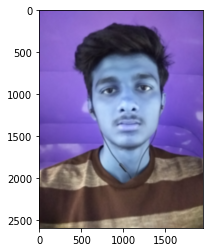

(2592, 1944, 3)


In [ ]:
img = cv2.imread(f'{train_path}/srijan_singh/IMG_20181025_174334.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

In [ ]:
# train and test images for each student
from os import scandir

print(f'Image Count:\n')
img_count = {}
for students in scandir(train_path):
  if students.is_dir():
    train_imgs = len([img.name for img in scandir(students) if not img.is_dir()])
    test_imgs = len([img.name for img in scandir(f'{test_path}/{students.name}') if not img.is_dir()])
    img_count[students.name] = [train_imgs, test_imgs]
    print(f'{students.name}(train={train_imgs}, test={test_imgs})')    

Image Count:

swapnil_chaudhari(train=6, test=2)
samrudh_uchil(train=8, test=3)
narendra_guru(train=9, test=5)
diksha_mulik(train=8, test=4)
punyak_deshmukh(train=6, test=4)
pragati_naik(train=11, test=4)
ritik_sharma(train=15, test=12)
ritu_singh(train=15, test=10)
srijan_singh(train=20, test=13)
tanmay_jadhav(train=18, test=10)
ritika_singh(train=11, test=5)
chaitanya_narayankar(train=12, test=6)
jatin_terde(train=9, test=2)
shreya_ketkar(train=15, test=11)
swapnil_patil(train=7, test=2)
rutvij_mane(train=5, test=5)
pratik_mishra(train=9, test=2)
sujan_wavekar(train=4, test=2)
ajinkya_vidwans(train=2, test=1)
prasad_raja(train=9, test=5)
kirti_kulkarni(train=12, test=10)
ayush_chaudhari(train=9, test=5)
akshay_dhayghude(train=5, test=1)
pavan_kulkarni(train=6, test=2)
muskan_singh(train=2, test=1)
dhanashree_dhanawade(train=7, test=5)
ruturaj_raut(train=4, test=3)
avdhut_shinde(train=4, test=4)
mahesh_patil(train=3, test=3)
shruti_vichare(train=5, test=5)
shyamal_nadwade(train=5, tes

In [ ]:
print(len(img_countt))
print(img_count['ayush_chaudhari'])

32
[4, 1]


# Data preparation

/mntDrive/My Drive/secomps/data/train/srijan_singh/IMG_20181025_174334.jpg --> [{'box': [633, 503, 838, 1108], 'confidence': 0.9999302625656128, 'keypoints': {'left_eye': (842, 954), 'right_eye': (1238, 929), 'nose': (1054, 1146), 'mouth_left': (900, 1365), 'mouth_right': (1224, 1355)}}]


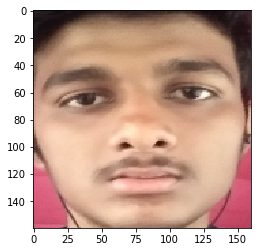

(160, 160, 3)


In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    #image = Image.open(filename)
    image = cv2.imread(filename)
    # convert to RGB, if needed
    #image = image.convert('RGB')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    print(f'{filename} --> {results}')
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face(f'{train_path}/srijan_singh/IMG_20181025_174334.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [ ]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset(f'{train_path}/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(f'{test_path}/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed(f'{data_path}/secomps-students-dataset.npz', trainX, trainy, testX, testy)

/mntDrive/My Drive/secomps/data/train/swapnil_chaudhari/IMG20190818105202 - Swap C.jpg --> [{'box': [1430, 2060, 1416, 1920], 'confidence': 0.9999988079071045, 'keypoints': {'left_eye': (1868, 2775), 'right_eye': (2558, 2852), 'nose': (2255, 3252), 'mouth_left': (1847, 3467), 'mouth_right': (2459, 3530)}}, {'box': [3870, 3067, 65, 90], 'confidence': 0.8142640590667725, 'keypoints': {'left_eye': (3892, 3100), 'right_eye': (3921, 3098), 'nose': (3908, 3118), 'mouth_left': (3894, 3137), 'mouth_right': (3917, 3135)}}]
/mntDrive/My Drive/secomps/data/train/swapnil_chaudhari/IMG_20190913_130123.jpg --> [{'box': [1535, 2138, 1598, 2101], 'confidence': 0.9998335838317871, 'keypoints': {'left_eye': (2387, 2906), 'right_eye': (3013, 2895), 'nose': (2918, 3411), 'mouth_left': (2458, 3794), 'mouth_right': (2962, 3744)}}]
/mntDrive/My Drive/secomps/data/train/swapnil_chaudhari/IMG_20190913_130121.jpg --> [{'box': [1310, 1825, 1501, 1952], 'confidence': 0.9999428987503052, 'keypoints': {'left_eye': 

# Generating embeddings of the dataset

In [ ]:
# loading the dataset
data = np.load(f'{data_path}/secomps-students-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (270, 160, 160, 3) (270,) (157, 160, 160, 3) (157,)


In [ ]:
# loading the model
facenet_model = load_model(f'{msceleb_model}/facenet_keras.h5')
facenet_model.load_weights(f'{msceleb_model}/facenet_keras_weights.h5')
print('Loaded Model')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model


In [ ]:
# calculating embeddings and saving those in a compressed file
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
# emdTrainX = list()
# for face in trainX:
#     emd = get_embedding(facenet_model, face)
#     emdTrainX.append(emd)
    
# emdTrainX = np.asarray(emdTrainX)
# print(emdTrainX.shape)

# # convert each face in the test set into embedding
# emdTestX = list()
# for face in testX:
#     emd = get_embedding(facenet_model, face)
#     emdTestX.append(emd)
# emdTestX = np.asarray(emdTestX)
# print(emdTestX.shape)

# # save arrays to one file in compressed format
# np.savez_compressed(f'{data_path}/secomps-students-embedding.npz', emdTrainX, trainy, emdTestX, testy)

# KNN and SVM classifier 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib 

# loading the embeddings
emd_data = np.load(f'{data_path}/secomps-students-embedding.npz')
emdTrainX, trainy, emdTestX, testy = emd_data['arr_0'], emd_data['arr_1'], emd_data['arr_2'], emd_data['arr_3']

# concatenating train and test embedding dataset
emdTTX = np.concatenate((emdTrainX, emdTestX), axis=0)
labels = np.concatenate((trainy, testy), axis=0)
images = np.concatenate((trainX, testX), axis=0)

print(f'emdTrainX = {emdTrainX.shape}  emdTestX = {emdTestX.shape}')
print(f'emdTTX = {emdTTX.shape}\nlabels = {labels.shape}')

print("\nDataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))

# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
emdTTX_norm = in_encoder.transform(emdTTX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
labels_enc = out_encoder.transform(labels)

# fit model
## svm
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)

## knn
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(emdTrainX_norm, trainy_enc)

# saving the trained model
# joblib.dump(knn, f'{model_path}/knn_classifier.pkl')
# joblib.dump(model, f'{model_path}/svc_classifier.pkl')

# predict
## svm
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
yhat_tt = model.predict(emdTTX_norm)

## knn
yhat_train_knn = knn.predict(emdTrainX_norm)
yhat_test_knn = knn.predict(emdTestX_norm)
yhat_tt_knn = knn.predict(emdTTX_norm)

# score
## svm
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
score_tt = accuracy_score(labels_enc, yhat_tt)

## knn
score_train_knn = accuracy_score(trainy_enc, yhat_train_knn)
score_test_knn = accuracy_score(testy_enc, yhat_test_knn)
score_tt_knn = accuracy_score(labels_enc, yhat_tt_knn)

# summarize
print(f'\nAccuracy:\nKNN --> train:{score_train_knn*100:.3f}, test:{score_test_knn*100:.3f}')
print(f'SVC --> train:{score_train*100:.3f}, test:{score_test*100:.3f}')

emdTrainX = (270, 128)  emdTestX = (157, 128)
emdTTX = (427, 128)
labels = (427,)

Dataset: train=270, test=157

Accuracy:
KNN --> train:100.000, test:99.363
SVC --> train:100.000, test:98.089


## Prediction

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(emdTTX_norm[idx1], emdTTX_norm[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(images[idx1])
    plt.subplot(122)
    plt.imshow(images[idx2]);

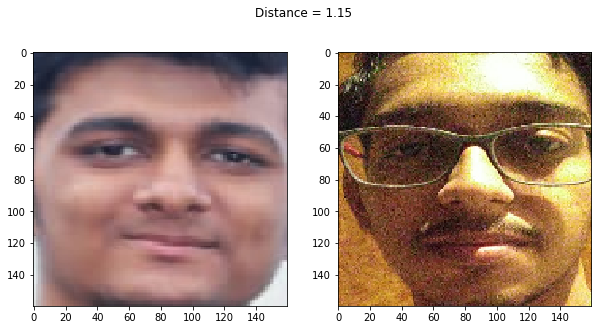

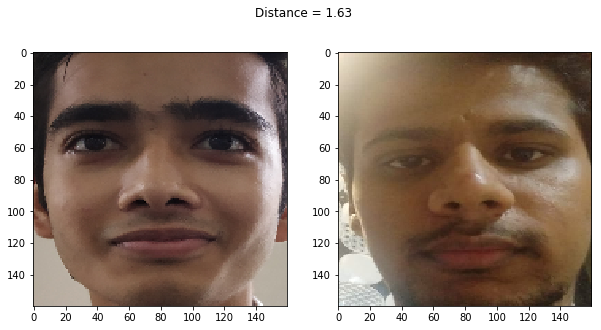

In [ ]:
show_pair(90,100)
show_pair(33,55)

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = images[example_idx]
    example_prediction = knn.predict([emdTTX_norm[example_idx]])
    example_identity = out_encoder.inverse_transform(example_prediction)[0]
    
    plt.axis('off')
    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = images[idx]
        example_prediction = knn.predict([emdTTX_norm[idx]])
        example_identity = out_encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

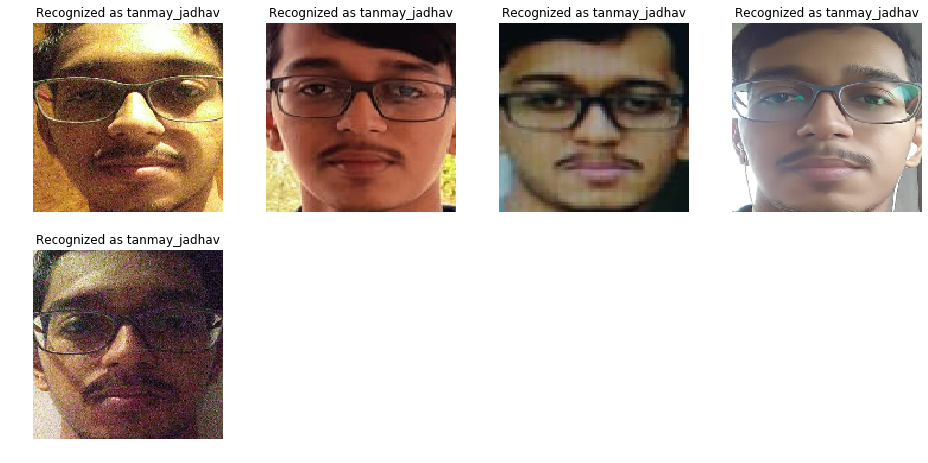

In [ ]:
show_predictions(range(100,105))

## Missclassfied images

[283]


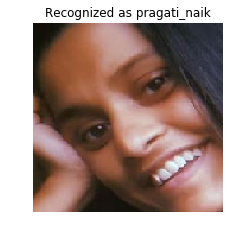

In [ ]:
error_pairs = []

for i, item in enumerate(yhat_tt_knn):
    if item != labels_enc[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)

# Calculating the best distance threshold

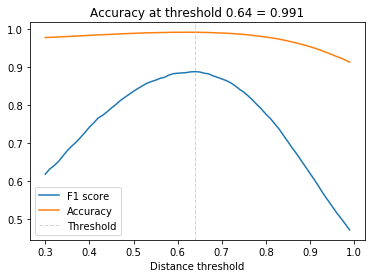

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(labels)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(emdTTX_norm[i], emdTTX_norm[j]))
        identical.append(1 if labels[i] == labels[j] else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Distance distribution of positive and negative pairs

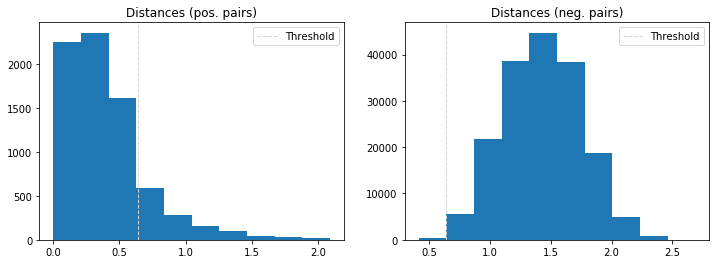

In [ ]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Dataset visualization

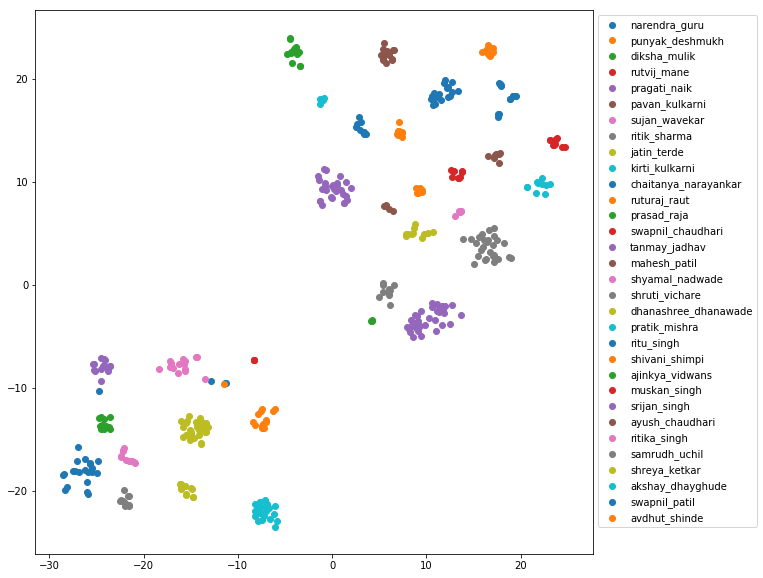

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(emdTTX)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(labels)):
    idx = labels == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

# Testing the model

Predicted: 
['ajinkya_vidwans' 'akshay_dhayghude' 'avdhut_shinde' 'ayush_chaudhari'
 'chaitanya_narayankar' 'dhanashree_dhanawade' 'diksha_mulik'
 'jatin_terde' 'kirti_kulkarni' 'mahesh_patil' 'muskan_singh'
 'narendra_guru' 'pavan_kulkarni' 'pragati_naik' 'prasad_raja'
 'pratik_mishra' 'punyak_deshmukh' 'ritik_sharma' 'ritika_singh'
 'ritu_singh' 'ruturaj_raut' 'rutvij_mane' 'samrudh_uchil'
 'shivani_shimpi' 'shreya_ketkar' 'shruti_vichare' 'shyamal_nadwade'
 'srijan_singh' 'sujan_wavekar' 'swapnil_chaudhari' 'swapnil_patil'
 'tanmay_jadhav'] 
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]
Expected: ritik_sharma


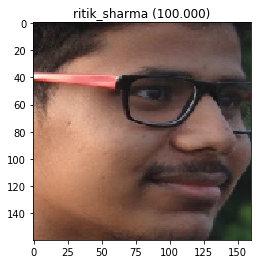

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = knn.predict(samples)
yhat_prob = knn.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([i for i in range(len(set(trainy)))])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

/mntDrive/My Drive/secomps/data/group_pictures/IMG_20190912_110456.jpg -->
[2399, 2055, 77, 95] - 0.9999996423721313
[2765, 2200, 106, 129] - 0.9999990463256836
[2495, 2029, 61, 72] - 0.9999977350234985
[2751, 2052, 78, 90] - 0.9999974966049194
[2650, 2119, 89, 114] - 0.999991774559021
[2278, 2176, 117, 146] - 0.9999825954437256
[2203, 2117, 83, 117] - 0.9994333386421204
[2464, 2797, 28, 37] - 0.9862902760505676
8


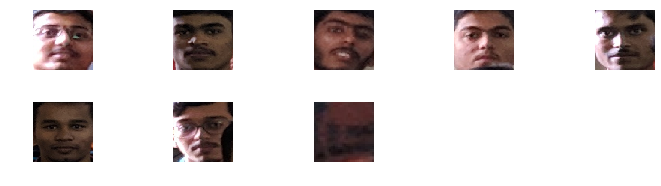

In [ ]:
# extract a multiple face from a given photograph
def extract_mul_faces(filename, required_size=(160, 160)):
    mul_faces = list()
    # load image from file
    #image = Image.open(filename)
    image = cv2.imread(filename)
    # convert to RGB, if needed
    #image = image.convert('RGB')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    print(f'{filename} -->')
    i = 0
    for face in results:
      # discard low conf 
      if results[i]['confidence'] < 0.95:
        continue
      print(f"{results[i]['box']} - {results[i]['confidence']}")  
      # extract the bounding box from the first face
      x1, y1, width, height = results[i]['box']
      # deal with negative pixel index
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      face = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(face)
      image = image.resize(required_size)
      #image = cv2.resize(image, required_size)
      face_array = np.asarray(image)
      mul_faces.append(face_array)
      i += 1
    return np.asarray(mul_faces)

# load the photo and extract the face
img = 'IMG_20190912_110456.jpg'
all_faces = extract_mul_faces(f'{data_path}/group_pictures/{img}')
print(len(all_faces))
plt.figure(figsize=(10,5))
i = 1
for f in all_faces:
  plt.subplot(4,5,i)
  plt.axis('off')
  plt.imshow(f)
  i += 1

plt.tight_layout()

In [ ]:
test_img_emb = list()
for face in all_faces:
  emd = get_embedding(facenet_model, face)
  test_img_emb.append(emd)
test_img_emb = np.asarray(test_img_emb)

test_img_emb_norm = in_encoder.transform(test_img_emb)

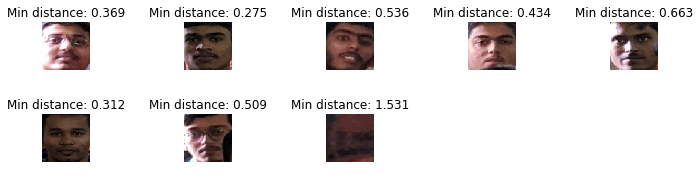

In [ ]:
i = 0
plt.figure(figsize=(10,5))
for i in range(len(test_img_emb_norm)):
  face_img = all_faces[i]
  for j in range(len(emdTestX_norm)):
    dist = []
    dist = [distance(test_img_emb_norm[i], emdTTX_norm[j])for j in range(len(emdTTX_norm))]
#   print(min(dist))
  min_dist = min(dist)
  plt.subplot(4,5,i+1)
  plt.axis('off')
  plt.title(f'Min distance: {min_dist:.3f}')
  plt.imshow(face_img)
  
plt.tight_layout()
  

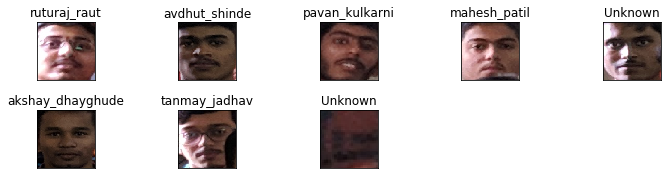

In [ ]:
i = 0
matched = False
# m = []
plt.figure(figsize=(10,5))
for i in range(len(test_img_emb_norm)):
  face_img = all_faces[i]
#   plt.subplot(2,4,i+1)
#   plt.imshow(face_img)
#   for j in range(len(emdTestX_norm)):
#   dist = []
#   dist = [distance(test_img_emb_norm[i], emdTestX_norm[j])for j in range(len(emdTestX_norm))]
#   print(min(dist))
# plt.show()
  for j in range(len(emdTestX_norm)):
    dist.append(distance(test_img_emb_norm[i], emdTestX_norm[j]))
    if distance(test_img_emb_norm[i], emdTestX_norm[j]) <= 0.64:
      matched = True
      break
    else:
      matched = False
      
  if matched == True:
    samples = np.expand_dims(test_img_emb_norm[i], axis=0)
    yhat_class = knn.predict(samples)
    yhat_prob = knn.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    all_names = out_encoder.inverse_transform([i for i in range(len(set(trainy)))])
    # plotting
    plt.subplot(4,5,i+1)
    plt.xticks([]), plt.yticks([])
    title = '%s' % (predict_names[0])
    plt.title(title)
    plt.imshow(face_img)
    
  else:
    # plotting
    plt.subplot(4,5,i+1)
    plt.xticks([]), plt.yticks([])
    plt.title('Unknown')
    plt.imshow(face_img)

# print(f'Minimum distances --> {m}')
plt.tight_layout()      

Predicted: 
['ajinkya_vidwans' 'akshay_dhayghude' 'avdhut_shinde' 'ayush_chaudhari'
 'chaitanya_narayankar' 'dhanashree_dhanawade' 'diksha_mulik'
 'jatin_terde' 'kirti_kulkarni' 'mahesh_patil' 'muskan_singh'
 'narendra_guru' 'pavan_kulkarni' 'pragati_naik' 'prasad_raja'
 'pratik_mishra' 'punyak_deshmukh' 'ritik_sharma' 'ritika_singh'
 'ritu_singh' 'ruturaj_raut' 'rutvij_mane' 'samrudh_uchil'
 'shivani_shimpi' 'shreya_ketkar' 'shruti_vichare' 'shyamal_nadwade'
 'srijan_singh' 'sujan_wavekar' 'swapnil_chaudhari' 'swapnil_patil'
 'tanmay_jadhav'] 
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 100.]


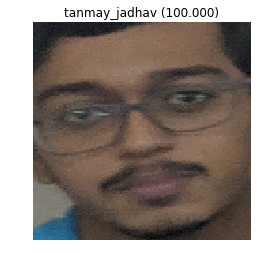

In [ ]:
import random
# select a random face from test set
index = random.randint(0, len(test_img_emb_norm)-1)
selection = test_img_emb_norm[index]

# prediction for the face
samples = np.expand_dims(selection, axis=0)
yhat_class = knn.predict(samples)
yhat_prob = knn.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([i for i in range(len(set(trainy)))])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
# print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(all_faces[index])
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.axis('off')
plt.show()